In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any, Dict
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import our HMM models
import sys
sys.path.append('../../')
from hidden_regime.data import DataLoader
from hidden_regime.analysis import RegimeAnalyzer
from hidden_regime.config import DataConfig

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


In [2]:
TICKER='AAPL'
NUM_DAYS=365
DATE_FORMAT='%Y-%m-%d'
NUM_STATES=4

In [3]:
data_config = DataConfig()
analyzer = RegimeAnalyzer(data_config)

current_date = datetime.now()
end_date = current_date.strftime(DATE_FORMAT)
start_date = (current_date - timedelta(days=NUM_DAYS)).strftime(DATE_FORMAT)

In [4]:
analysis = analyzer.analyze_stock(symbol=TICKER, start_date=start_date, end_date=end_date, n_states=NUM_STATES)

In [5]:
print(f'As of {end_date}, {TICKER} is predicted to be {analysis['current_regime']} ({analysis['confidence']:.2%} confidence)')

As of 2025-09-14, AAPL is predicted to be State_3 (65.35% confidence)


In [6]:
data_loader = DataLoader(data_config)
data = data_loader.load_stock_data(TICKER, start_date, end_date)

In [7]:
def create_regime_visualization(data: pd.DataFrame, analysis: Dict[str, Any]):
    """Create a comprehensive regime analysis visualization"""
    
    # Set up the plot style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Market Regime Analysis: {analysis["symbol"]}', 
                 fontsize=16, fontweight='bold')
    
    # Get returns from data (already calculated)
    returns = data['returns'].dropna() - 1.0
    
    # 1. Price chart with regime backgrounds
    ax1 = axes[0, 0]
    states = analysis['states']
    
    # Create regime colors
    regime_colors = {0: 'red', 1: 'gray', 2: 'blue'}
    regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}
    
    # Plot price
    price_dates = data['date'].iloc[-len(states):]
    ax1.plot(price_dates, data['price'].iloc[-len(states):], 'k-', linewidth=1.5, alpha=0.8)
    
    # Add regime backgrounds
    current_regime = states[0]
    start_idx = 0
    
    for i in range(1, len(states)):
        if states[i] != current_regime or i == len(states) - 1:
            end_idx = i if states[i] != current_regime else i + 1
            color = regime_colors.get(current_regime, 'gray')
            ax1.axvspan(price_dates[start_idx], price_dates[end_idx-1], 
                       alpha=0.2, color=color, label=regime_names.get(current_regime, f'State {current_regime}') if start_idx == 0 else "")
            current_regime = states[i]
            start_idx = i
    
    ax1.set_title('Price with Regime Detection', fontweight='bold')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Returns with regime coloring
    ax2 = axes[0, 1]
    return_dates = data['date'].iloc[-len(returns):]
    
    for state in range(3):
        state_mask = states == state
        if np.any(state_mask):
            state_returns = returns.iloc[-len(states):].iloc[state_mask]
            state_dates = return_dates.iloc[state_mask]
            ax2.scatter(state_dates, state_returns, c=regime_colors.get(state, 'gray'), 
                       alpha=0.6, s=20, label=regime_names.get(state, f'State {state}'))
    
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_title('Returns by Regime', fontweight='bold')
    ax2.set_ylabel('Daily Returns')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Regime probabilities over time
    ax3 = axes[1, 0]
    probabilities = analysis['probabilities']
    prob_dates = data['date'].iloc[-len(probabilities):]
    
    for state in range(3):
        ax3.plot(prob_dates, probabilities[:, state], 
                label=regime_names.get(state, f'State {state}'),
                color=regime_colors.get(state, 'gray'), linewidth=2)
    
    ax3.set_title('Regime Probabilities Over Time', fontweight='bold')
    ax3.set_ylabel('Probability')
    ax3.set_ylim(0, 1)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Regime statistics
    ax4 = axes[1, 1]
    regime_stats = analysis['regime_stats']
    
    states_list = []
    returns_list = []
    volatility_list = []
    
    for state_key, stats in regime_stats.items():
        state_num = int(state_key.split('_')[1])
        states_list.append(regime_names.get(state_num, f'State {state_num}'))
        returns_list.append(stats['annualized_return'])
        volatility_list.append(stats['annualized_volatility'])
    
    x = np.arange(len(states_list))
    width = 0.35
    
    bars1 = ax4.bar(x - width/2, [r*100 for r in returns_list], width, 
                   label='Annualized Return (%)', alpha=0.8)
    bars2 = ax4.bar(x + width/2, [v*100 for v in volatility_list], width,
                   label='Annualized Volatility (%)', alpha=0.4)
    
    # Color bars by regime
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        color = regime_colors.get(i, 'gray')
        bar1.set_color(color)
        bar2.set_color(color)
        bar2.set_hatch('o')
        bar2.set_alpha(0.6)
    
    ax4.set_title('Regime Characteristics', fontweight='bold')
    ax4.set_ylabel('Percentage (%)')
    ax4.set_xticks(x)
    ax4.set_xticklabels(states_list)
    ax4.legend(['Return', 'Volatility'])
    ax4.grid(True, alpha=0.3)
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

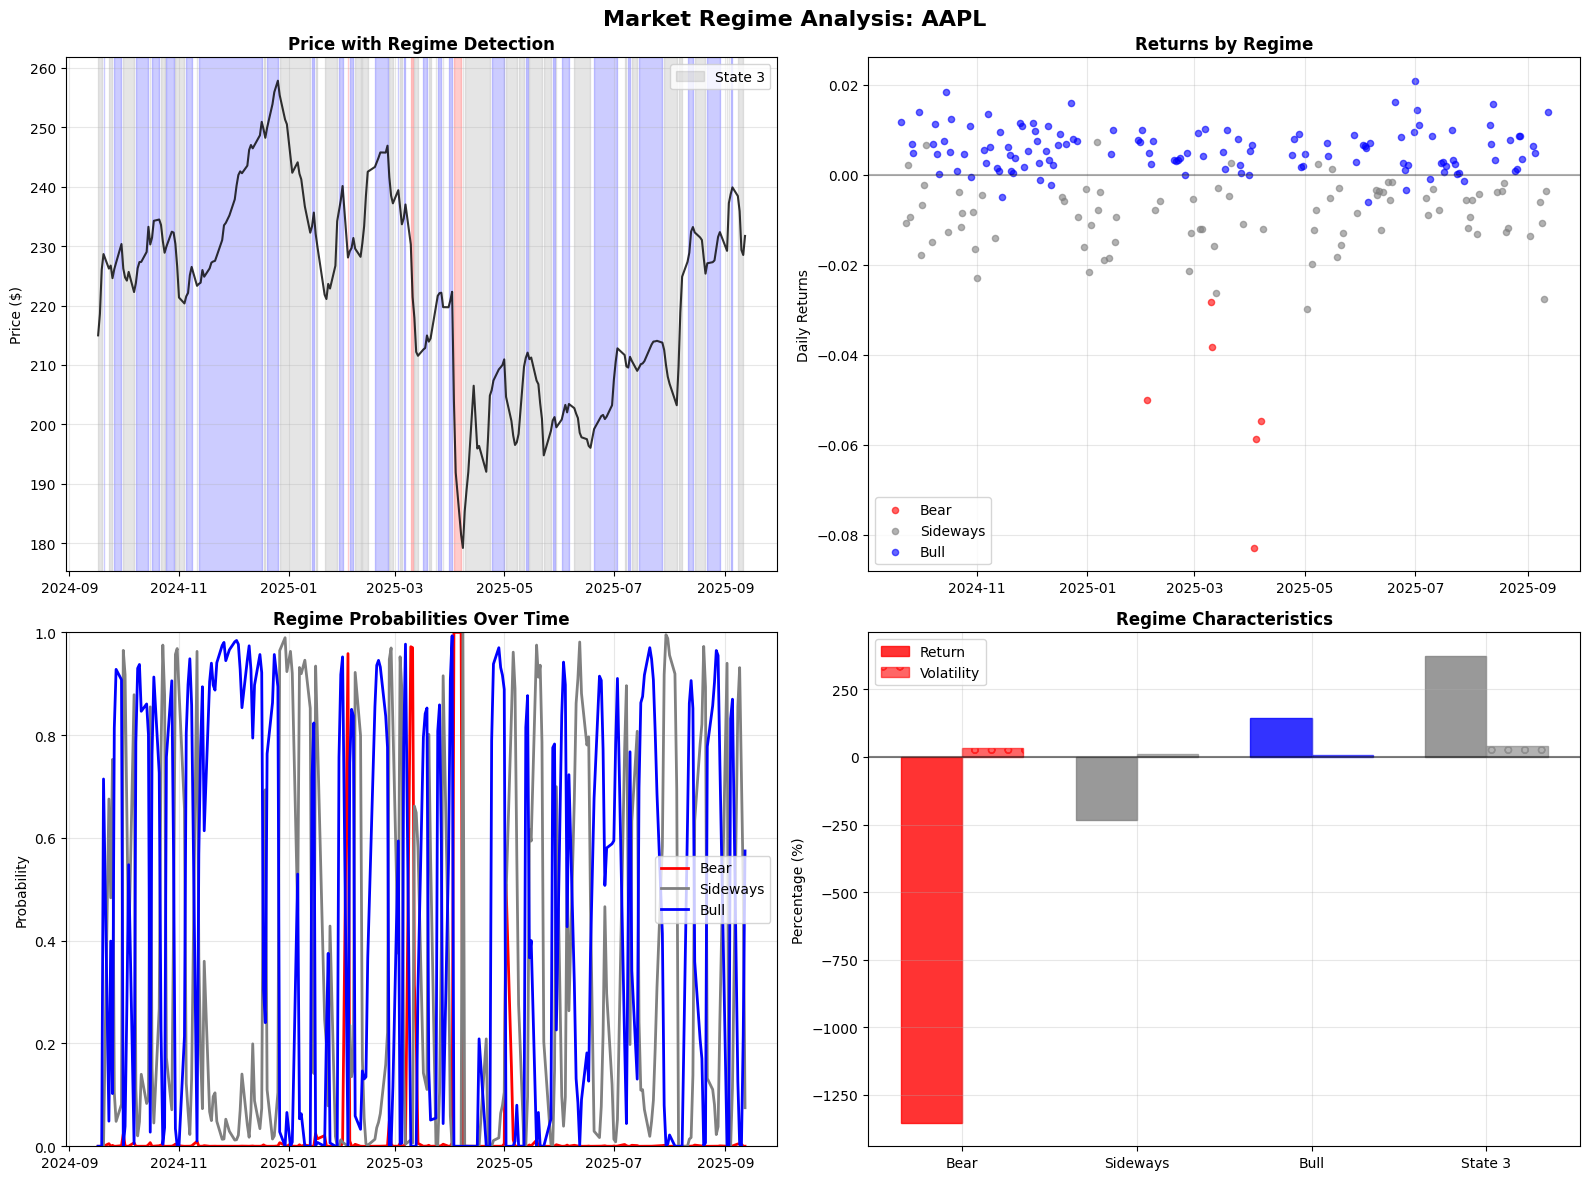

In [8]:
create_regime_visualization(data, analysis)

In [9]:
100*(data.returns-1)

0     -0.006955
1      1.684154
2      3.394464
3      1.163694
4     -1.067599
         ...   
243   -0.607610
244   -1.067454
245   -2.770566
246   -0.364092
247    1.401518
Name: returns, Length: 248, dtype: float64

In [ ]:
analysis